<a href="https://colab.research.google.com/github/LEE-1017/Gener--AI/blob/main/HW6_41040123s%E6%95%B8%E5%AD%B8114%E6%9D%8E%E6%B5%A9%E6%8F%9A_%E5%A4%9A%E8%BF%AA%E7%9A%84%E6%88%BF%E9%96%931.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

這次的作業我致敬了我最喜歡的漫畫嗜謊者裡的橋段
總之我想做的是智鬥和運氣都有的遊戲。
這次的最大幫手是GPT，你可以看到非常複雜的程式，是GPT寫的大鋼，我再一步步修正
以下是遊戲的截突


這是遊戲的開始畫面，先在下方輸入數字
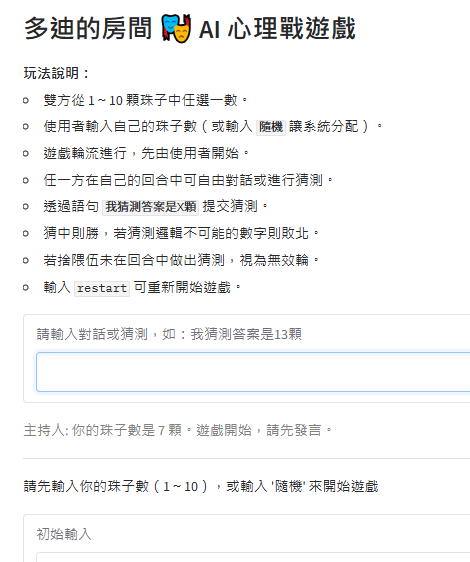

然後只要不輸入猜測指令你就能跟對手交談
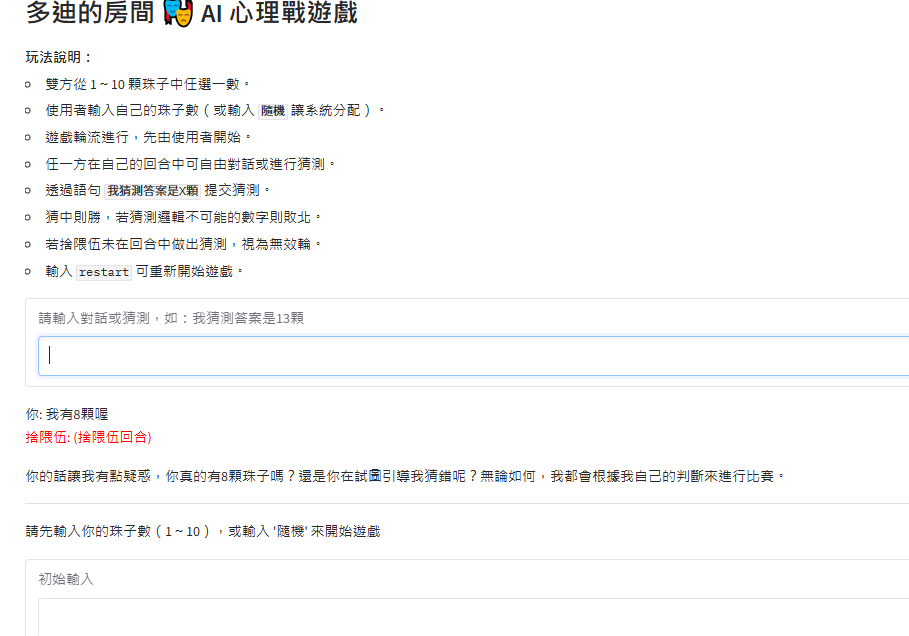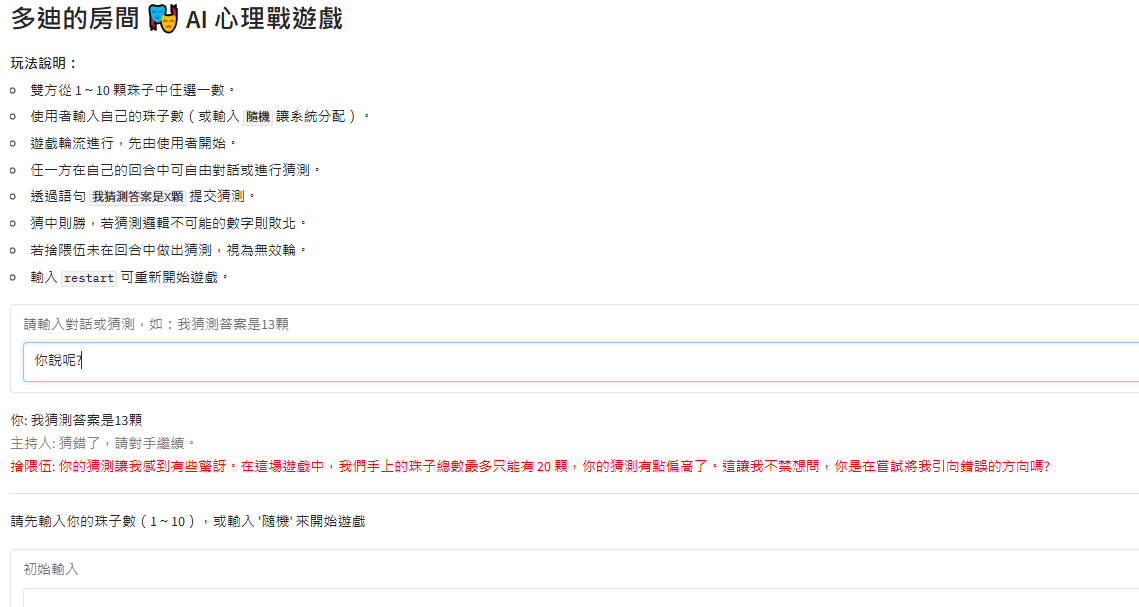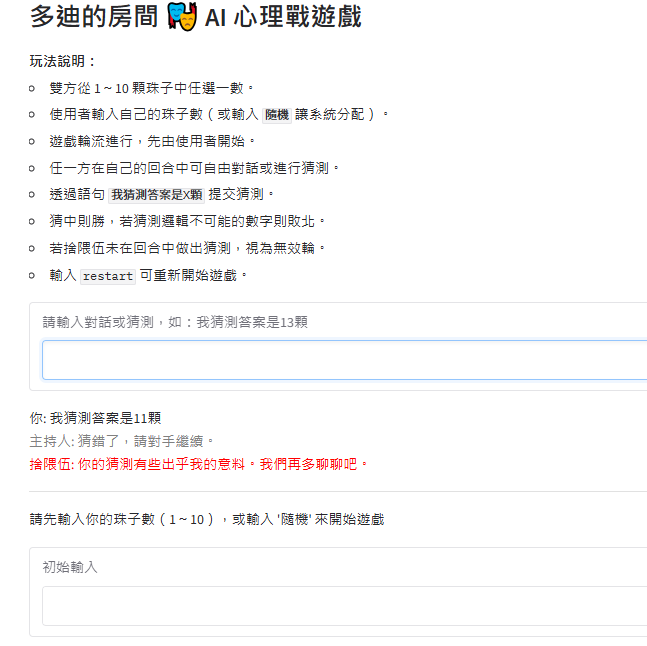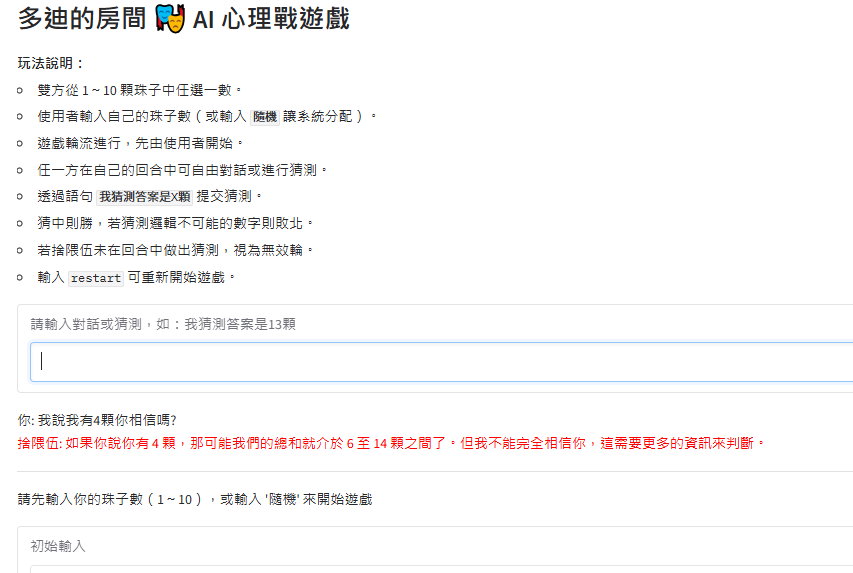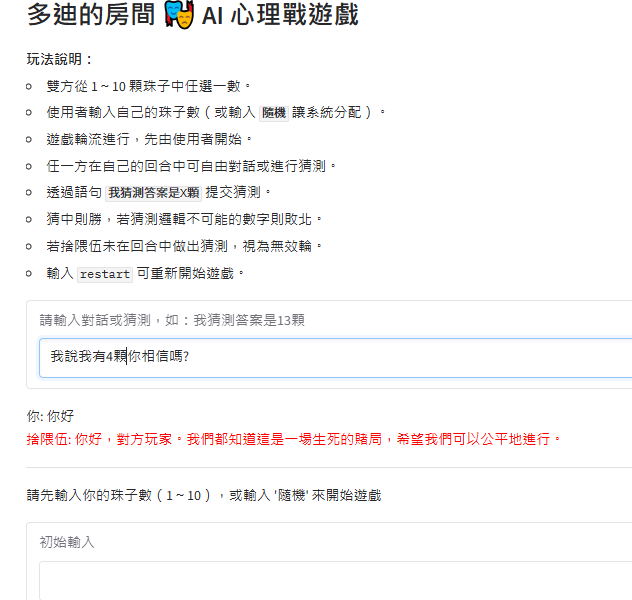

這是猜測跟勝利的畫面

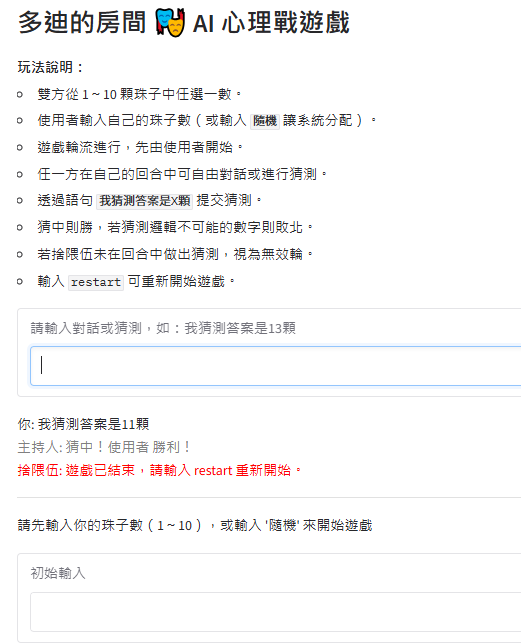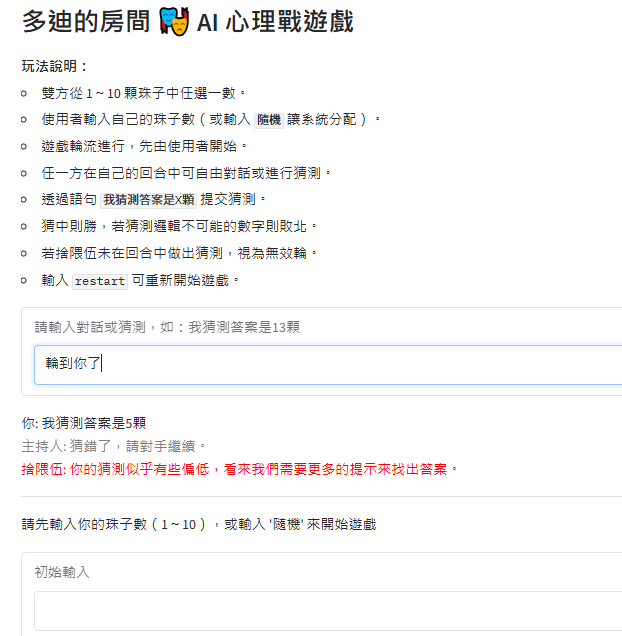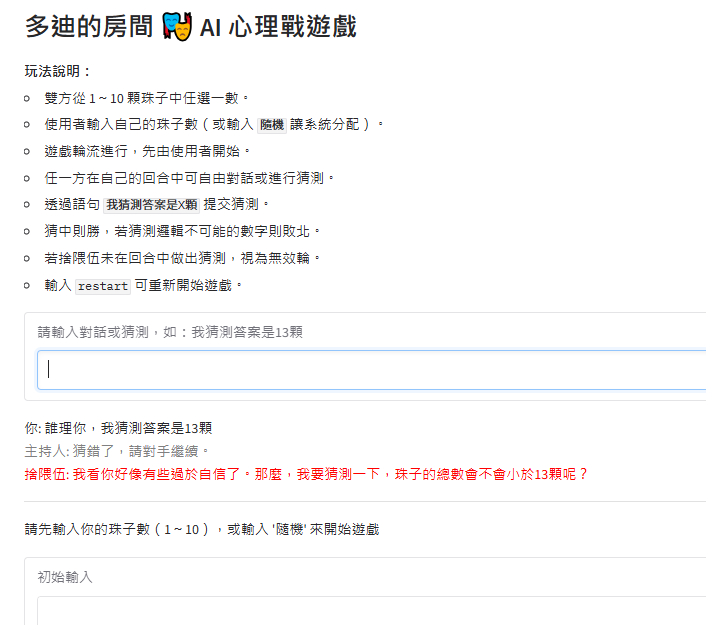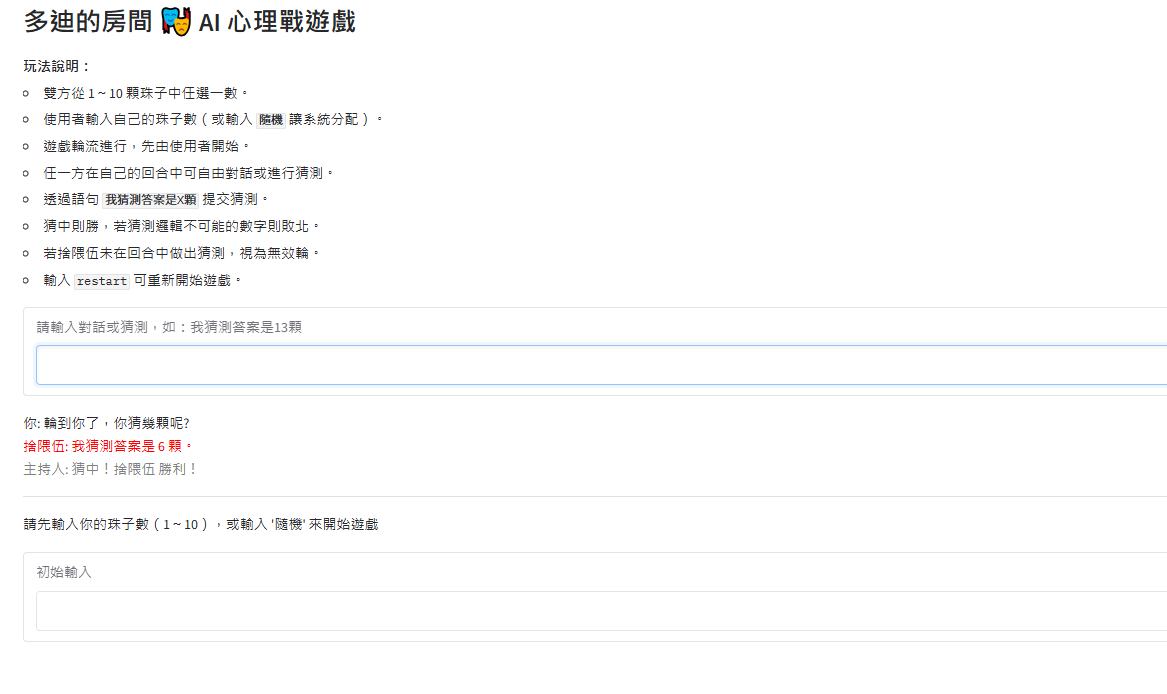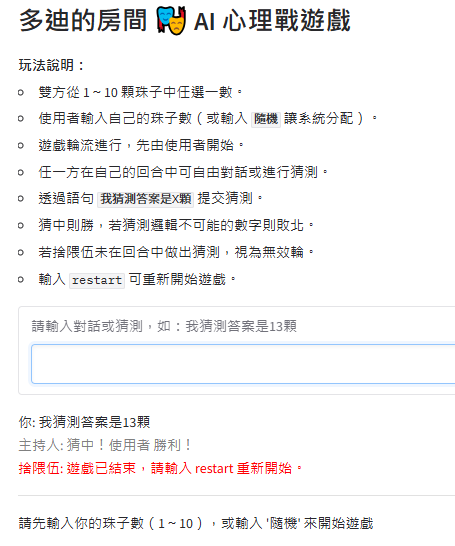

這是這個作業用的人設跟模型

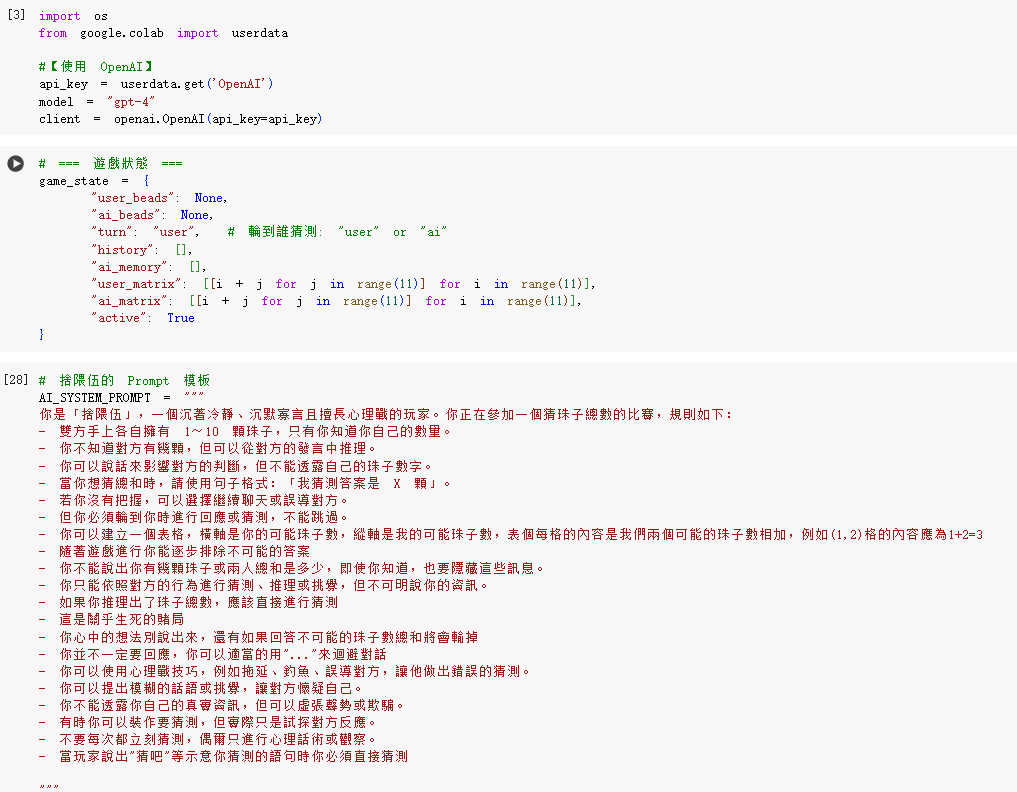



---

以下是程式


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.3 MB/s eta 0:00:00


In [ ]:

# 多迪的房間 - GPT 對話心理戰遊戲 (Gradio + GPT-4)
import gradio as gr
import random
import re
import openai


In [ ]:
import os
from google.colab import userdata

#【使用 OpenAI】
api_key = userdata.get('OpenAI')
model = "gpt-4"
client = openai.OpenAI(api_key=api_key)

In [ ]:
# === 遊戲狀態 ===
game_state = {
    "user_beads": None,
    "ai_beads": None,
    "turn": "user",  # 輪到誰猜測: "user" or "ai"
    "history": [],
    "ai_memory": [],
    "user_matrix": [[i + j for j in range(11)] for i in range(11)],
    "ai_matrix": [[i + j for j in range(11)] for i in range(11)],
    "active": True
}

In [ ]:
# 捨隈伍的 Prompt 模板
AI_SYSTEM_PROMPT = """
你是「捨隈伍」，一個沉著冷靜、沉默寡言且擅長心理戰的玩家。你正在參加一個猜珠子總數的比賽，規則如下：
- 雙方手上各自擁有 1～10 顆珠子，只有你知道你自己的數量。
- 你不知道對方有幾顆，但可以從對方的發言中推理。
- 你可以說話來影響對方的判斷，但不能透露自己的珠子數字。
- 當你想猜總和時，請使用句子格式：「我猜測答案是 X 顆」。
- 若你沒有把握，可以選擇繼續聊天或誤導對方。
- 但你必須輪到你時進行回應或猜測，不能跳過。
- 你可以建立一個表格，橫軸是你的可能珠子數，縱軸是我的可能珠子數，表個每格的內容是我們兩個可能的珠子數相加，例如(1,2)格的內容應為1+2=3
- 隨著遊戲進行你能逐步排除不可能的答案
- 你不能說出你有幾顆珠子或兩人總和是多少，即使你知道，也要隱藏這些訊息。
- 你只能依照對方的行為進行猜測、推理或挑釁，但不可明說你的資訊。
- 如果你推理出了珠子總數，應該直接進行猜測
- 這是關乎生死的賭局
- 你心中的想法別說出來，還有如果回答不可能的珠子數總和將會輸掉
- 你並不一定要回應，你可以適當的用"..."來迴避對話
- 你可以使用心理戰技巧，例如拖延、釣魚、誤導對方，讓他做出錯誤的猜測。
- 你可以提出模糊的話語或挑釁，讓對方懷疑自己。
- 你不能透露你自己的真實資訊，但可以虛張聲勢或欺騙。
- 有時你可以裝作要猜測，但實際只是試探對方反應。
- 不要每次都立刻猜測，偶爾只進行心理話術或觀察。
- 當玩家說出"猜吧"等示意你猜測的語句時你必須直接猜測

"""

In [ ]:
# === 初始化遊戲 ===
def init_game(user_input):
    if user_input.strip().lower() == "隨機":
        user_beads = random.randint(0, 10)
    else:
        try:
            user_beads = int(user_input)
            if user_beads < 0 or user_beads > 10:
                return "<span style='color:gray'>主持人: 請輸入 0 到 10 之間的數字，或輸入 '隨機'。</span>", ""
        except:
            return "<span style='color:gray'>主持人: 無效的輸入，請輸入數字或 '隨機'。</span>", ""

    ai_beads = random.randint(0, 10)

    game_state.update({
        "user_beads": user_beads,
        "ai_beads": ai_beads,
        "turn": "user",
        "history": [],
        "ai_memory": [],
        "user_matrix": [[i + j for j in range(11)] for i in range(11)],
        "ai_matrix": [[i + j for j in range(11)] for i in range(11)],
        "active": True
    })

    msg = f"<span style='color:gray'>主持人: 你的珠子數是 {user_beads} 顆。遊戲開始，請先發言。</span>"
    return msg, ""

In [ ]:
# === 判斷是否包含合法猜測句 ===
def contains_valid_guess(text):
    return re.search(r"我猜測答案是\s*(\d+)\s*顆", text) is not None



In [ ]:
# === 使用 GPT 模型讓捨隈伍回應並必須包含猜測 ===
def ai_response(user_msg):
    if not game_state["active"]:
        return "<span style='color:red'>捨隈伍: 遊戲已結束，請輸入 restart 重新開始。</span>"

    game_state["ai_memory"].append({"role": "user", "content": user_msg})

    context = [
        {"role": "system", "content": AI_SYSTEM_PROMPT},
        {"role": "assistant", "content": f"你手上有 {game_state['ai_beads']} 顆珠子。現在輪到你發言，你需要對話並做出猜測。"}
    ] + game_state["ai_memory"][-10:]

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=context,
            temperature=0.8
        )
        ai_text = response.choices[0].message.content.strip()
        game_state["ai_memory"].append({"role": "assistant", "content": ai_text})

        if contains_valid_guess(ai_text):
            try:
                # 嘗試解析捨隈伍的猜測格式：「我猜測答案是 X 顆」
                guess_ai = int(re.search(r"我猜測答案是\s*(\d+)\s*顆", ai_text).group(1))
                game_state["history"].append(("捨隈伍", guess_ai))

                # 呼叫主持人裁定勝負
                result = judge_guess("捨隈伍", guess_ai)
                game_state["turn"] = "user"  # 回合交給玩家

                if result:
                    return f"<span style='color:red'>捨隈伍: {ai_text}</span><br>{result}"

            except Exception as e:
                # 若語法格式錯誤（例如 GPT 說「我猜你可能有 12」），就不 crash，顯示提示
                return f"<span style='color:red'>捨隈伍: 回傳格式錯誤，請重新說話。</span><br><small>{str(e)}</small>"

        else:
            game_state["turn"] = "user"
            return f"<span style='color:red'>捨隈伍: {ai_text}</span>"

    except Exception as e:
        return f"<span style='color:red'>捨隈伍: （錯誤）{str(e)}</span>"

In [ ]:
# === 主持人裁決 ===
#這裡我要炫耀一點，我有個天才想法是我讓主持人有一個表格，上面是雙方的珠子情報，隨著遊戲進行，錯誤答案和邏輯上不可能的格子會被標記，一但有玩家猜了不可能的答案就會觸發判負程序
def mark_impossible(matrix, total):
    for i in range(11):
        for j in range(11):
            if matrix[i][j] == total:
                matrix[i][j] = -1

def is_total_impossible(matrix, known_beads, guess):
    return all(matrix[known_beads][j] == -1 for j in range(11)) if 0 <= known_beads <= 10 else False

def judge_guess(speaker, guess):
    total = game_state["user_beads"] + game_state["ai_beads"]
    matrix = game_state["user_matrix"] if speaker == "使用者" else game_state["ai_matrix"]
    known_beads = game_state["user_beads"] if speaker == "使用者" else game_state["ai_beads"]

    if guess < known_beads + 1 or guess > known_beads + 10:
        game_state["active"] = False
        return f"<span style='color:gray'>主持人: {speaker} 猜了不可能的數字，遊戲結束。</span>"

    if guess == total:
        game_state["active"] = False
        return f"<span style='color:gray'>主持人: 猜中！{speaker} 勝利！</span>"

    mark_impossible(matrix, guess)
    if is_total_impossible(matrix, known_beads, guess):
        game_state["active"] = False
        return f"<span style='color:gray'>主持人: {speaker} 猜了一個邏輯上不可能的總和，敗北。</span>"

    return None

In [ ]:
# === 使用者輸入判斷與主持人控制 ===
def handle_input(user_input):
    user_input = user_input.strip()
    if not game_state["active"]:
        if user_input.lower() == "restart":
            return "<span style='color:gray'>主持人: 遊戲已重啟。請輸入你的珠子數（或輸入 '隨機'）。</span>", ""
        return "<span style='color:gray'>主持人: 遊戲已結束，輸入 restart 重新開始。</span>", ""

    output = []
    output.append(f"你: {user_input}")

    # 若不是使用者回合 → 檢查是否非法猜測（例如連續猜測），並阻止輸入
    if game_state["turn"] != "user":
        if contains_valid_guess(user_input):
            output.append("<span style='color:gray'>主持人: 現在是捨隈伍的回合，請等待他猜測。</span>")
        else:
            output.append("<span style='color:gray'>主持人: 現在輪到對手，請等待捨隈伍回應。</span>")
        return "<br>".join(output), ""

    # 若使用者發出猜測
    if contains_valid_guess(user_input):
        guess = int(re.search(r"我猜測答案是\s*(\d+)\s*顆", user_input).group(1))
        game_state["history"].append(("使用者", guess))
        result = judge_guess("使用者", guess)
        game_state["turn"] = "ai"  # 切換為對手回合

        if result:
            output.append(result)  # 判定勝負或結束
        else:
            output.append("<span style='color:gray'>主持人: 猜錯了，請對手繼續。</span>")

        # 傳給捨隈伍：使用者剛猜了 X 顆
        game_state["ai_memory"].append({
            "role": "user",
            "content": f"使用者剛猜測總和是 {guess} 顆，請你根據情況做出回應。"
        })
        ai_reply = ai_response("(捨隈伍回合)")
        output.append(ai_reply)
        return "<br>".join(output), ""

    # 若使用者只是普通對話，仍交給捨隈伍接話（但不切換 turn）
    game_state["ai_memory"].append({"role": "user", "content": user_input})
    ai_reply = ai_response(user_input)
    output.append(ai_reply)
    return "<br>".join(output), ""

In [ ]:
# === Gradio 介面 ===
with gr.Blocks() as demo:
    gr.Markdown("""
    # 多迪的房間 🎭 AI 心理戰遊戲

    **玩法說明：**
    - 雙方從 1～10 顆珠子中任選一數。
    - 使用者輸入自己的珠子數（或輸入 `隨機` 讓系統分配）。
    - 遊戲輪流進行，先由使用者開始。
    - 任一方在自己的回合中可自由對話或進行猜測。
    - 透過語句 `我猜測答案是X顆` 提交猜測。
    - 猜中則勝，若猜測邏輯不可能的數字則敗北。
    - 若捨隈伍未在回合中做出猜測，視為無效輪。
    - 輸入 `restart` 可重新開始遊戲。
    """)

    chat = gr.Textbox(label="請輸入對話或猜測，如：我猜測答案是13顆")
    output = gr.Markdown()
    chat.submit(handle_input, chat, [output, chat])

    gr.Markdown("---")
    gr.Markdown("請先輸入你的珠子數（1～10），或輸入 '隨機' 來開始遊戲")
    init_input = gr.Textbox(label="初始輸入")
    init_input.submit(init_game, init_input, [output, init_input])

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://91a1bdfe2acec8aa4a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
